In [137]:
import matplotlib.pyplot as plt


# predict the next characters given the previous characters
1. using bigram model i.e. two characters at a time

In [138]:
words = open("names.txt",'r').read().splitlines() #read the file as list of words

In [139]:
words[:10], len(words)

(['emma',
  'olivia',
  'ava',
  'isabella',
  'sophia',
  'charlotte',
  'mia',
  'amelia',
  'harper',
  'evelyn'],
 32033)

In [140]:
min([len(w) for w in words]), max([len(w) for w in words])

(2, 15)

In [141]:
# b = {}
# for w in words:
#     ch = ['<S>'] + list(w) + ['<E>']
#     for c1,c2 in zip(ch,ch[1:]):  # w is emma and w[1:] is mma so zip will give tupples em,mm,ma and return if one is shorter
#         bigram = (c1, c2)
#         b[bigram] = b.get(bigram,0) + 1

# simplest way to find the probability of a character given the previous character is to count the number of times it occurs

In [142]:
# sorted(b.items(), key=lambda x: x[1], reverse=True)[:10]

In [143]:
import torch

In [144]:
chars = sorted(list(set((''.join(words)))))
SI = {c:i+1 for i,c in enumerate(chars)} # char to index
SI['<.>'] = 0  # convention to add special characters as <X>

IS = {i:c for c,i in SI.items()} # index to char
IS

{1: 'a',
 2: 'b',
 3: 'c',
 4: 'd',
 5: 'e',
 6: 'f',
 7: 'g',
 8: 'h',
 9: 'i',
 10: 'j',
 11: 'k',
 12: 'l',
 13: 'm',
 14: 'n',
 15: 'o',
 16: 'p',
 17: 'q',
 18: 'r',
 19: 's',
 20: 't',
 21: 'u',
 22: 'v',
 23: 'w',
 24: 'x',
 25: 'y',
 26: 'z',
 0: '<.>'}

In [145]:
SI

{'a': 1,
 'b': 2,
 'c': 3,
 'd': 4,
 'e': 5,
 'f': 6,
 'g': 7,
 'h': 8,
 'i': 9,
 'j': 10,
 'k': 11,
 'l': 12,
 'm': 13,
 'n': 14,
 'o': 15,
 'p': 16,
 'q': 17,
 'r': 18,
 's': 19,
 't': 20,
 'u': 21,
 'v': 22,
 'w': 23,
 'x': 24,
 'y': 25,
 'z': 26,
 '<.>': 0}

In [146]:
N = torch.zeros((27,27),dtype=torch.int32)  #26 alphabets + <S> and <E>

for w in words:
    ch = ['<.>'] + list(w) + ['<.>']
    for c1,c2 in zip(ch,ch[1:]):  # w is emma and w[1:] is mma so zip will give tupples em,mm,ma and return if one is shorter
        i1 = SI[c1]
        i2 = SI[c2]
        N[i1,i2] += 1
    

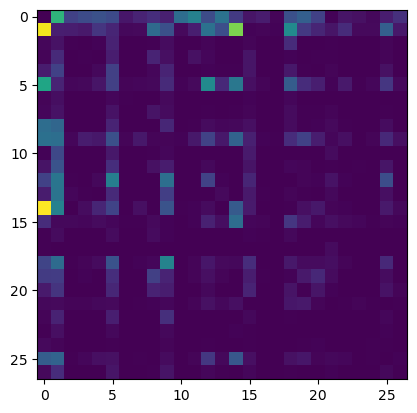

In [147]:
plt.imshow(N)

(-0.5, 26.5, 26.5, -0.5)

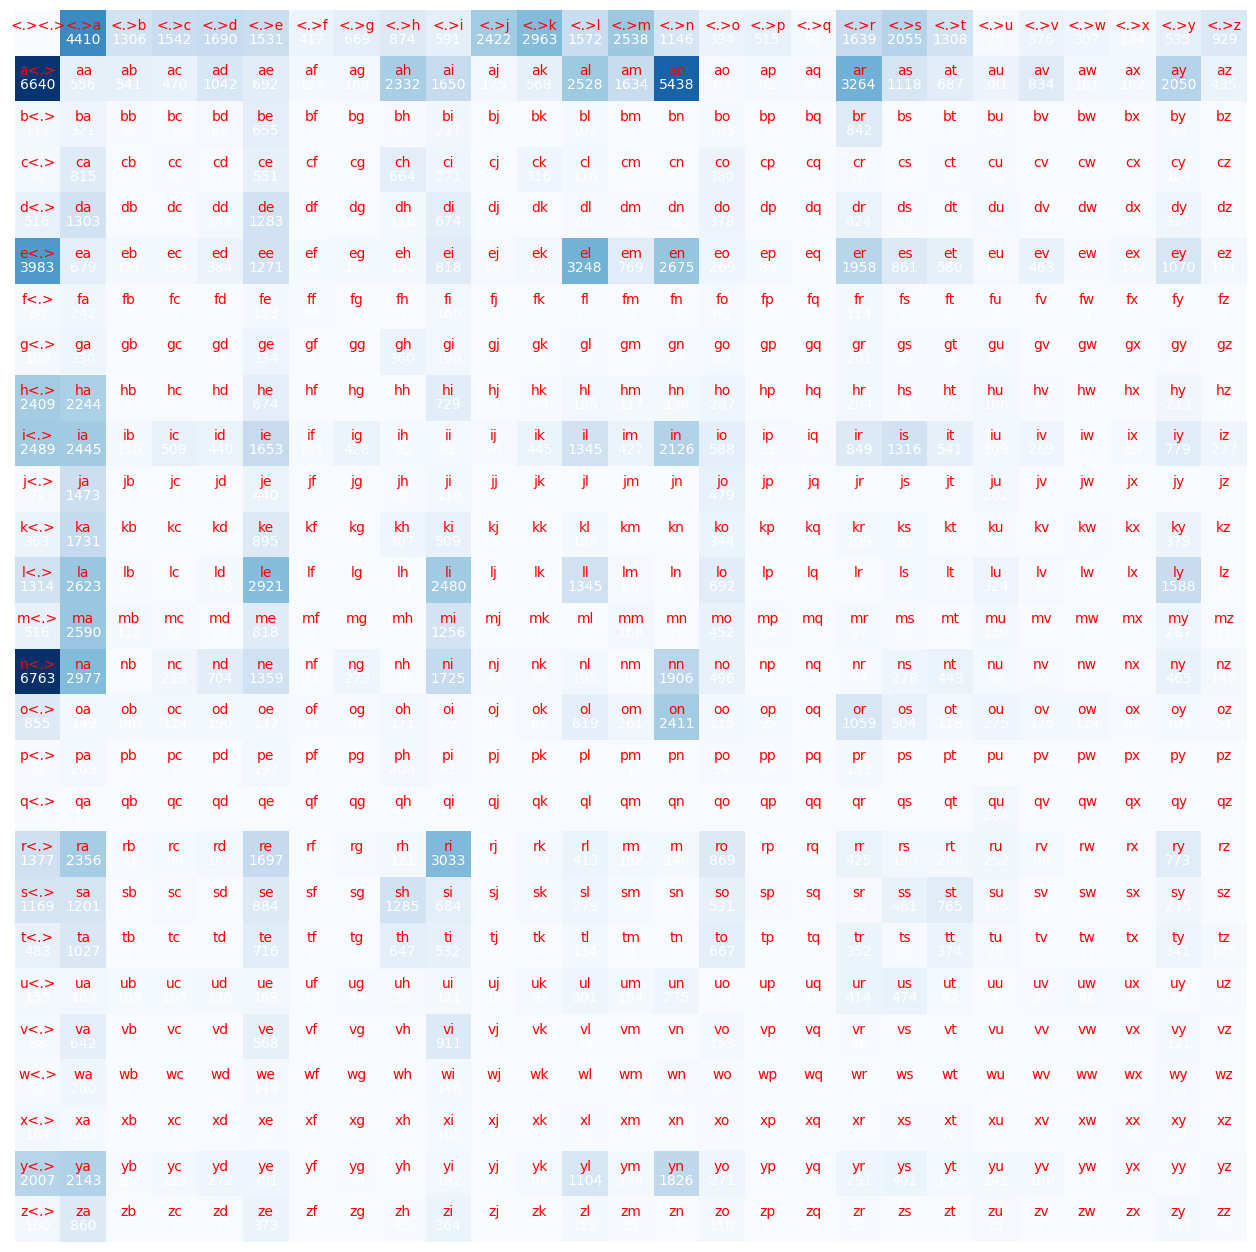

In [148]:
plt.figure(figsize=(16,16))
plt.imshow(N,cmap='Blues')
for i in range(27):
    for j in range(27):
        chs = IS[i] + IS[j]
        plt.text(j,i,chs,ha='center',va='bottom',color='red')
        plt.text(j,i,N[i,j].item(),ha='center',va='top',color='white')
plt.axis('off')

In [149]:
# sample from the distribution using multinomial and generator

In [150]:
# p = N[0].float() / N[0].sum()
# 
# g = torch.Generator().manual_seed(421)
# p = torch.rand(3, generator=g)
# p = p / p.sum()
# p

In [151]:
# samples = torch.multinomial(p, num_samples=20, replacement=True, generator=g)  # 40% chance of 0, 41% chance of 1, 17% chance of 2

In [152]:
# index = torch.multinomial(p, num_samples=1, replacement=True, generator=g).item() 
# IS[index]

In [153]:
# save probabilities beforehand to avoid recomputing
P = (N+1).float()  # add 1 to avoid 0 probabilities
# p = p/ x is outplace operation 
P /=  torch.sum(P, dim=1, keepdim=True)           # dim=1 means sum along the rows and keepdim=True means keep the dimension of the sum [27,1] instead of [27] (squeeze)
# https://youtu.be/PaCmpygFfXo?si=IWlBUImwmwJD_klY&t=2820
# theoretically dim=1 is not required as sum is a scalar, but it is required for broadcasting due to a bug in pytorch and it normalizes columns
# dim won't change the numbers as the orignal matrix is a bigram 
P[0].sum()

tensor(1.)

# to decide if a matrix operation is possible torch provides broadcasting semetics
 https://pytorch.org/docs/stable/notes/broadcasting.html
# an operation is possible if the dimensions are same or one of them is 1 or if one of them is a scalar
# in this case P is [27,27] and otehr is [27,1] so it is possible as p[0] is broadcasted to [27,27]

In [154]:
g = torch.Generator().manual_seed(2147483647)  # set a generator to sample from the distribution
for i in range(10):
    output = []
    index = 0 # init
    while True:
        p = P[index]            # get the distribution for the index
        # p = N[index].float()    # get the distribution for the index
        # p = p / p.sum()        # normalize
        # p = torch.ones(27) / 27  # uniform distribution equivalent to an untrained model
        index = torch.multinomial(p, num_samples=1, replacement=True, generator=g).item() # sample from the distribution
        output.append(IS[index])
        if index == 0: # if <.> then break
            break
    print(''.join(output))

cexze<.>
momasurailezitynn<.>
konimittain<.>
llayn<.>
ka<.>
da<.>
staiyaubrtthrigotai<.>
moliellavo<.>
ke<.>
teda<.>


In [155]:
log_L = 0.
n = 0
for w in words:
    ch = ['<.>'] + list(w) + ['<.>']
    for c1,c2 in zip(ch,ch[1:]):  # w is emma and w[1:] is mma so zip will give tupples em,mm,ma and return if one is shorter
        i1 = SI[c1]
        i2 = SI[c2]
        prob = P[i1,i2] 
        log_prob = torch.log(prob)
        log_L += log_prob
        n += 1
        # print(f'{c1} -> {c2} : {prob:.4f}  {log_prob:.4f} ')
N_log_L = - log_L
avg_log_L = N_log_L / n
print(f'negative log likelihood: {N_log_L:.4f}  avg: {avg_log_L:.4f}')
print(f'perplexity: {torch.exp(N_log_L/n):.4f}')

negative log likelihood: 559951.5625  avg: 2.4544
perplexity: 11.6389


https://en.wikipedia.org/wiki/Maximum_likelihood_estimation#:~:text=In%20statistics%2C%20maximum%20likelihood%20estimation,observed%20data%20is%20most%20probable.

# GOAL
1. maximize the likelihood / log likelihood of the data
2. minimize the negative log likelihood of the data

##  using a neural network

In [156]:
# create a dataset
import torch.nn.functional as F
xs, ys = [], [] 
for w in words:
    ch = ['<.>'] + list(w) + ['<.>']  
    for c1,c2 in zip(ch,ch[1:]):  # w is emma and w[1:] is mma so zip will give tupples em,mm,ma and return if one is shorter
        i1 = SI[c1]
        i2 = SI[c2]
        xs.append(i1)
        ys.append(i2)
        
xs = torch.tensor(xs)
ys = torch.tensor(ys)  # torch.Tensor() does same but always returns float tensor whereas .tensor has dtype arg
num = xs.nelement() # number of elements
print(f"number of elements: {num}")

# interpret the output as log of counts : exp(log_counts)
g = torch.Generator().manual_seed(2147483647)  # set a generator to sample from the distribution
W  = torch.randn((27,27),requires_grad=True,generator=g)  # normal distribution of weights
# 27 neurons in layer and 27 weights for each neuron


number of elements: 228146


In [157]:
# gradient descent
for i in range(100):
    eX = F.one_hot(xs, num_classes = 27).float()  #input to the network
    
    # forward pass
    logits = eX @ W # matrix multiplication (log counts)
    counts = torch.exp(logits) # equivalent to N

    # softmax to get probabilities
    probs = counts / counts.sum(dim=1, keepdims=True) # equivalent to P
    loss = -(probs[torch.arange(num), ys]).log().mean()  # alternative way to compute the loss but as vector
    print(loss)
    
    #backward pass
    W.grad = None
    loss.backward(retain_graph=True)
    
    #update 
    W.data -= 50 * W.grad

# loss is about the same as by just counting
# though with this approach we can use more than one layer/bigram and non-linearities

tensor(3.7590, grad_fn=<NegBackward0>)
tensor(3.3711, grad_fn=<NegBackward0>)
tensor(3.1540, grad_fn=<NegBackward0>)
tensor(3.0204, grad_fn=<NegBackward0>)
tensor(2.9277, grad_fn=<NegBackward0>)
tensor(2.8604, grad_fn=<NegBackward0>)
tensor(2.8097, grad_fn=<NegBackward0>)
tensor(2.7701, grad_fn=<NegBackward0>)
tensor(2.7381, grad_fn=<NegBackward0>)
tensor(2.7115, grad_fn=<NegBackward0>)
tensor(2.6890, grad_fn=<NegBackward0>)
tensor(2.6697, grad_fn=<NegBackward0>)
tensor(2.6529, grad_fn=<NegBackward0>)
tensor(2.6383, grad_fn=<NegBackward0>)
tensor(2.6254, grad_fn=<NegBackward0>)
tensor(2.6140, grad_fn=<NegBackward0>)
tensor(2.6039, grad_fn=<NegBackward0>)
tensor(2.5948, grad_fn=<NegBackward0>)
tensor(2.5867, grad_fn=<NegBackward0>)
tensor(2.5794, grad_fn=<NegBackward0>)
tensor(2.5728, grad_fn=<NegBackward0>)
tensor(2.5668, grad_fn=<NegBackward0>)
tensor(2.5613, grad_fn=<NegBackward0>)
tensor(2.5563, grad_fn=<NegBackward0>)
tensor(2.5516, grad_fn=<NegBackward0>)
tensor(2.5474, grad_fn=<N

In [160]:
# sampling
g = torch.Generator().manual_seed(2147483647)
for i in range(10):
    output = []
    index = 0 # init
    while True:
        eX = F.one_hot(torch.tensor(index), num_classes = 27).float()
        logits = eX @ W
        counts = torch.exp(logits)
        p = counts / counts.sum(dim=0, keepdims=True)
        index = torch.multinomial(p, num_samples=1, replacement=True, generator=g).item() 
        output.append(IS[index])
        if index == 0: # if <.> then break
            break
    print(''.join(output))

cexze<.>
momasurailezityha<.>
konimittain<.>
llayn<.>
ka<.>
da<.>
staiyauelalerigotai<.>
moliellavo<.>
ke<.>
teda<.>


 * logits = eX @ W
 * since ex are in the form [0,0,1,0,0,0]
 * eX @ W becomes the dimension of eX where it is 1

* if some probabilty is 0 here exp(0) turns them to 1 
* which is same as smoothing as (P+1)
* or it can be regularized as
* loss =  loss + ".01 * (W**2).mean()"  which also prevents overfitting
* https://www.kaggle.com/code/sid321axn/regularization-techniques-in-deep-learning